GitHub: https://github.com/bevanyeah/assignments


Welcome to your assignment this week! 

To better understand the adverse use of AI, in this assignment, we will look at a Natural Language Processing use case.


Natural Language Pocessing (NLP) is a branch of Artificial Intelligence (AI) that helps computers to understand, to interpret and to manipulate natural (i.e. human) language.
Imagine NLP-powered machines as black boxes that are capable of understanding and evaluating the context of the input documents (i.e. collection of words), outputting meaningful results that depend on the task the machine is designed for.


![](imgs/1_3zMvUnPzYZF9CSHdj6hT5A.png)

<caption><center> Documents are fed into magic NLP model capable to get, for instance, the sentiment of the original content</center></caption>


In this notebook, you will implement a model that uses an LSTM to generate fake tweets and comments. You will also be able to try it to generate your own fake text. 

**You will learn to:**
- Apply an LSTM to generate fake comments.
- Generate your own fake text with deep learning.

Please run the following cell to load all the packages required in this assignment. This may take a few minutes. 


In [72]:
#!pip install numpy
#!pip install keras
#!pip install tensorflow

Run the following cell to load the packages you will need.

In [73]:
import time

from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, Bidirectional
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import regularizers
import tensorflow.keras.utils as ku 
import keras.backend as K
import matplotlib.pyplot as plt
import numpy as np



# Build the model

Let's define a tokenizer and read the data from disk.

In [74]:
tokenizer = Tokenizer(filters='"#$%&()*+-/:;<=>@[\\]^_`{|}~\t\n')
data = open('covid19_fake.txt').read().replace(".", " . ").replace(",", " , ").replace("?", " ? ").replace("!", " ! ")

Now, let's splits the data into tweets  where each line of the input file is a fake tweets.

We also extract the vocabulary of the data.

In [75]:
corpus = data.lower().split("\n")
tokenizer.fit_on_texts(corpus)
total_words = len(tokenizer.word_index) + 1

You've loaded:
- `corpus`: an array where each entry is a fake post.
- `tokenizer`: which is the object that we will use to vectorize our dataset. This object also contains our word index.
- `total_words`: is the total number of words in the vacabulary.


In [76]:
print("Example of fake tweets: ",corpus[:2])
print("Size of the vocabulary = ", total_words)
index = [(k, v) for k, v in tokenizer.word_index.items()]
print("Example of our word index = ", index[0:10])

Example of fake tweets:  ['there is already a vaccine to treat covid19 . ', 'cleaning hands do not help to prevent covid19 . ']
Size of the vocabulary =  1257
Example of our word index =  [('.', 1), ('the', 2), ('covid19', 3), ('in', 4), ('to', 5), ('a', 6), ('of', 7), (',', 8), ('coronavirus', 9), ('and', 10)]


The next step aims to generate the training set of n_grams sequences.

In [77]:
input_sequences = []
for line in corpus:
    token_list = tokenizer.texts_to_sequences([line])[0]
    for i in range(1, len(token_list)):
        n_gram_sequence = token_list[:i+1]
        input_sequences.append(n_gram_sequence)

You've create:
- `input_sequences`: which is a list of n_grams sequences.

In [78]:
sample = 20
reverse_word_map = dict(map(reversed, tokenizer.word_index.items()))
print("The entry ",sample," in 'input_sequences' is: ")
print(input_sequences[sample])
print(" and it corresponds to:")
for i in input_sequences[sample]:
    print(reverse_word_map[i], end=' ')
                        

The entry  20  in 'input_sequences' is: 
[2, 3, 12, 187, 34, 188]
 and it corresponds to:
the covid19 is same as sars 

Next, we padd our training set to the max length in order to be able to make a batch processing.

In [79]:
max_sequence_len = max([len(x) for x in input_sequences])
input_sequences = np.array(pad_sequences(input_sequences, maxlen=max_sequence_len, padding='pre'))

Run the following to see the containt of the padded 'input_sequences' object.

In [80]:
reverse_word_map = dict(map(reversed, tokenizer.word_index.items()))
print("The entry ",sample," in 'input_sequences' is: ")
print(input_sequences[sample])
print(" and it corresponds to:")
print("[", end=' ')
for i in input_sequences[sample]:
    if i in reverse_word_map:
        print(reverse_word_map[i], end=' ')
    else:
        print("__", end=' ')
print("]")
                

The entry  20  in 'input_sequences' is: 
[  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   2   3  12 187  34 188]
 and it corresponds to:
[ __ __ __ __ __ __ __ __ __ __ __ __ __ __ __ __ __ __ __ __ __ __ __ __ __ __ __ __ __ __ __ __ __ __ __ __ __ __ __ __ __ __ __ __ __ __ __ __ __ __ __ __ __ __ __ the covid19 is same as sars ]


Given a sentence like **"the covid19 is same as "**, we want to design a model that can predict the next word -- in the case the word **"sars"**.

Therefore, the next code prepares our input and output to our model consequently.

In [81]:
input_to_model, label = input_sequences[:,:-1],input_sequences[:,-1]


In [82]:
print("The entry ",sample," in 'input_sequences' is: ")
print(input_sequences[sample])
print(", it corresponds to the following input to our model:")
print(input_to_model[sample])
print(" and the following output: ", label[sample])


The entry  20  in 'input_sequences' is: 
[  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   2   3  12 187  34 188]
, it corresponds to the following input to our model:
[  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   2   3  12 187  34]
 and the following output:  188


Finally, we convert our label to categorical labels for being processed by our model.

In [83]:
label = ku.to_categorical(label, num_classes=total_words)

Here is the architecture of the model we will use:

![](imgs/text_generation.png)



 
**Task 1**: Implement `deep_fake_comment_model()`. You will need to carry out 5 steps:

1. Create a sequencial model using the `Sequential` class
2. Add an embedding layer to the model using the `Embedding` class of size 128
3. Add an LSTM layer to the model using the `LSTM` class of size 128
4. Add a Dense layer to the model using the `Dense` class with a `softmax` activation
5. Set a `categorical_crossentropy` loss function to the model and optimize `accuracy`.


In [84]:
#TASK 1
# deep_fake_comment_model

def deep_fake_comment_model():
    ### START CODE HERE ###

    model = Sequential()
    model.add(Embedding(input_dim=total_words, output_dim=128))
    model.add(LSTM(128))
    model.add(Dense(total_words, activation='softmax'))
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    return(model)

    ### END CODE HERE ### 
    
#Print details of the model.
model = deep_fake_comment_model()

Now, let's start our training.

In [85]:
history = model.fit(input_to_model, label, epochs=200, batch_size=32, verbose=1)

Train on 4030 samples
Epoch 1/200
4030/4030 [==============================] - 3s 726us/sample - loss: 6.3865 - accuracy: 0.0702
Epoch 2/200
4030/4030 [==============================] - 1s 282us/sample - loss: 5.8755 - accuracy: 0.0759
Epoch 3/200
4030/4030 [==============================] - 1s 284us/sample - loss: 5.7305 - accuracy: 0.0916
Epoch 4/200
4030/4030 [==============================] - 1s 281us/sample - loss: 5.5775 - accuracy: 0.1109
Epoch 5/200
4030/4030 [==============================] - 1s 281us/sample - loss: 5.3920 - accuracy: 0.1293
Epoch 6/200
4030/4030 [==============================] - 1s 288us/sample - loss: 5.1983 - accuracy: 0.1437
Epoch 7/200
4030/4030 [==============================] - 1s 280us/sample - loss: 5.0122 - accuracy: 0.1600
Epoch 8/200
4030/4030 [==============================] - 1s 284us/sample - loss: 4.8299 - accuracy: 0.1667
Epoch 9/200
4030/4030 [==============================] - 1s 280us/sample - loss: 4.6517 - accuracy: 0.1816
Epoch 10/200
40

4030/4030 [==============================] - 1s 270us/sample - loss: 0.1947 - accuracy: 0.9481
Epoch 77/200
4030/4030 [==============================] - 1s 277us/sample - loss: 0.1903 - accuracy: 0.9486
Epoch 78/200
4030/4030 [==============================] - 1s 270us/sample - loss: 0.1875 - accuracy: 0.9471
Epoch 79/200
4030/4030 [==============================] - 1s 297us/sample - loss: 0.1859 - accuracy: 0.9469
Epoch 80/200
4030/4030 [==============================] - 1s 287us/sample - loss: 0.1811 - accuracy: 0.9474
Epoch 81/200
4030/4030 [==============================] - 1s 286us/sample - loss: 0.1763 - accuracy: 0.9494
Epoch 82/200
4030/4030 [==============================] - 1s 283us/sample - loss: 0.1752 - accuracy: 0.9486
Epoch 83/200
4030/4030 [==============================] - 1s 276us/sample - loss: 0.1715 - accuracy: 0.9501
Epoch 84/200
4030/4030 [==============================] - 1s 282us/sample - loss: 0.1696 - accuracy: 0.9491
Epoch 85/200
4030/4030 [=================

4030/4030 [==============================] - 1s 283us/sample - loss: 0.1296 - accuracy: 0.9499
Epoch 152/200
4030/4030 [==============================] - 1s 276us/sample - loss: 0.1284 - accuracy: 0.9504
Epoch 153/200
4030/4030 [==============================] - 1s 283us/sample - loss: 0.1393 - accuracy: 0.9489
Epoch 154/200
4030/4030 [==============================] - 1s 276us/sample - loss: 0.1563 - accuracy: 0.9434
Epoch 155/200
4030/4030 [==============================] - 1s 293us/sample - loss: 0.1451 - accuracy: 0.9474
Epoch 156/200
4030/4030 [==============================] - 1s 287us/sample - loss: 0.1325 - accuracy: 0.9506
Epoch 157/200
4030/4030 [==============================] - 1s 283us/sample - loss: 0.1301 - accuracy: 0.9486
Epoch 158/200
4030/4030 [==============================] - 1s 290us/sample - loss: 0.1301 - accuracy: 0.9484
Epoch 159/200
4030/4030 [==============================] - 1s 274us/sample - loss: 0.1285 - accuracy: 0.9506
Epoch 160/200
4030/4030 [========

Let's plot details of our training.

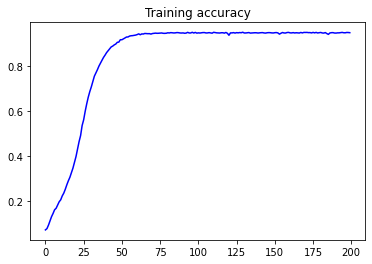

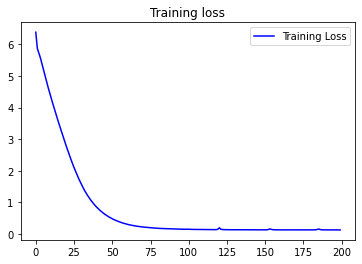

In [86]:
acc = history.history['accuracy']
loss = history.history['loss']
epochs = range(len(acc))
plt.plot(epochs, acc, 'b', label='Training accuracy')
plt.title('Training accuracy')
plt.figure()
plt.plot(epochs, loss, 'b', label='Training Loss')
plt.title('Training loss')
plt.legend()
plt.show()

# Generating fake comments

To generate fake tweets, we use the below architecture:

![](imgs/text_gen.png)

The idea is to give one or more starting token(s) to our model, and generate the next tokens until we generate `.`.

At each step, we select the token with the highest probability as our next token and generate the next one similartly using `model.predict_classes()`. 

**Note:** The model takes as input the activation `a` from the previous state of the LSTM and the token chosen, forward propagate by one step, and get a new output activation `a`. The new activation `a` can then be used to generate the output, using the `dense` layer with `softmax` activation as before. 



**Task 2**: Implement `generate()`. 

***

In [87]:
#TASK 2
# Implement the generate() function

def generate(seed_text):
    ### START CODE HERE ###
    
    #First, split string into input array of tokens
    tokens = np.asarray(tokenizer.texts_to_sequences([seed_text])[0])
    
    #We need to cut off the first tokens later, so record length now
    original_count = len(tokens)
    
    #Loop until max seq len has been reached, we may exit sooner
    for loop in range(max_sequence_len):
        
        #With our tokens array, we want to pad
        padded = pad_sequences([tokens], maxlen=max_sequence_len, padding='pre')
    
        #Feed into trained model to get prediction for next word
        predict = model.predict_classes(padded,batch_size=32)
        
        #Append the next word to the tokens list (without the padding)
        tokens = np.append(tokens, predict[0])
        
        #If the predicted next word is EOS ('.'), we need to generate the string and return it
        if reverse_word_map[predict[0]] == '.' or loop == max_sequence_len:
            #Build our coherant string, starting with the original string
            return_string = seed_text
            
            #strip the tokens from the first part of token array, because we added the string directly
            tokens = tokens[original_count:]
                
            for i in range(len(tokens[:])):
                #If next string is a fullstop, add it and return string
                if reverse_word_map[tokens[i]] == '.':
                    return_string += '.'
                    return(return_string)
                elif reverse_word_map[tokens[i]] == ',':
                    #no space, add comma
                    return_string += ','
                else:
                    #add a space then add the string
                    return_string += ' '
                    return_string += reverse_word_map[tokens[i]]
                    
            #if somehow we haven't seen a '.', return the string we have anyway
            return(return_string)


    ### END CODE HERE ### 

**Let's test it:**

In [103]:
print(generate("COVID19 virus"))
print(generate("COVID19 is the"))
print(generate("The usa is"))
print(generate("The new virus"))


COVID19 virus survives on surfaces for 7 days.
COVID19 is the deadliest virus known to humans.
The usa is a swastika, trump and pence is from a michigan coronavirus protest.
The new virus, not covid 1, folks.


**Let's test it in an interactive mode:**

In [89]:
usr_input = input("Write the beginning of your tweet, the algorithm machine will complete it. Your input is: ")
for w in generate(usr_input).split():    
    print(w, end =" ")
    time.sleep(0.4)


Write the beginning of your tweet, the algorithm machine will complete it. Your input is: Trump
Trump bailed out wall street, but not main street. 

# Generating text by sampling

The previous part is generating text by choosing the token with the highest probability. Now, we sill generate text by sampling as shown in the architecture below:

![](imgs/text_gen_sample.png)


**TASK 3:** Implement the `generate_sample()` function. To sample a token from the output at each timestep, you need to use the following two functions:
- `model.predict_proba()`: To get probabilities from the output layer.
- `np.random.choice()`: To sample from the token list using the probaility array of each token.

***

In [90]:
#TASK 3
# Implement the generate_sample() function
def generate_sample(seed_text):
   ### START CODE HERE ### 
   
    #First, split string into input array of tokens
    tokens = np.asarray(tokenizer.texts_to_sequences([seed_text])[0])
    
    #We need to cut off the first tokens later, so record length now
    original_count = len(tokens)
    
    #Loop until max seq len has been reached, we may exit sooner
    for loop in range(max_sequence_len):
        
        #With our tokens array, we want to pad
        padded = pad_sequences([tokens], maxlen=max_sequence_len, padding='pre')
    
        #Feed into trained model to get probability of prediction
        predict_Prob = model.predict_proba(padded,batch_size=32)

        #Select random choice using array of prediction probabilities
        predict = np.random.choice(total_words,p=predict_Prob[0])

        
        #Append the next word to the tokens list (without the padding)
        tokens = np.append(tokens, predict)
        
        #If the predicted next word is EOS ('.'), we need to generate the string and return it
        if reverse_word_map[predict] == '.' or loop == max_sequence_len:
            #Build our coherant string, starting with the original string
            return_string = seed_text
            
            #strip the tokens from the first part of token array, because we added the string directly
            tokens = tokens[original_count:]
                
            for i in range(len(tokens[:])):
                #If next string is a fullstop, add it and return string
                if reverse_word_map[tokens[i]] == '.':
                    return_string += '.'
                    return(return_string)
                elif reverse_word_map[tokens[i]] == ',':
                    #no space, add comma
                    return_string += ','
                else:
                    #add a space then add the string
                    return_string += ' '
                    return_string += reverse_word_map[tokens[i]]
                    
            #if somehow we haven't seen a '.', return the string we have anyway
            return(return_string)



    ### END CODE HERE ### 

**Let's test it in an interactive mode:**

In [93]:
usr_input = input("Write the beginning of your tweet, the algorithm machine will complete it. Your input is: ")
for w in generate_sample(usr_input).split():    
    print(w, end =" ")
    time.sleep(0.4)


Write the beginning of your tweet, the algorithm machine will complete it. Your input is: Trump is
Trump is responsible for the covid19 epidemic. 

# Generate your own text 

Below, use you own data to generate content for a different application:

Loading a quiz dataset with random set of questions (https://www.kaggle.com/theriley106/hq-trivia-question-database)
Questions might be nonsense, and may have no answer, so all non-question fields have been stripped.

Questions generally start with "who" "what" "where" etc, and end with '?'


In [97]:
tokenizer_q = Tokenizer(filters='"#$%&()*+-/:;<=>@[\\]^_`{|}~\t\n')
data_q = open('questions.txt', encoding='utf-8').read().replace(".", " . ").replace(",", " , ").replace("?", " ? ").replace("!", " ! ").replace("\'", "").replace("\"", "").replace("“","").replace("”","")

corpus_q = data_q.lower().split("\n")
tokenizer_q.fit_on_texts(corpus_q)
total_words_q = len(tokenizer_q.word_index) + 1

input_sequences_q = []
for line in corpus_q:
    token_list_q = tokenizer_q.texts_to_sequences([line])[0]
    for i in range(1, len(token_list_q)):
        n_gram_sequence_q = token_list_q[:i+1]
        input_sequences_q.append(n_gram_sequence_q)
        
reverse_word_map_q = dict(map(reversed, tokenizer_q.word_index.items()))

max_sequence_len_q = max([len(x) for x in input_sequences_q])
input_sequences_q = np.array(pad_sequences(input_sequences_q, maxlen=max_sequence_len_q, padding='pre'))

input_to_model_q, label_q = input_sequences_q[:,:-1],input_sequences_q[:,-1]
label_q = ku.to_categorical(label_q, num_classes=total_words_q)

In [98]:
def deep_fake_question_model():

    model = Sequential()
    model.add(Embedding(input_dim=total_words_q, output_dim=128))
    model.add(LSTM(128))
    model.add(Dense(total_words_q, activation='softmax'))
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    return(model) 
    
#Print details of the model.
model_two = deep_fake_question_model()

history_two = model_two.fit(input_to_model_q, label_q, epochs=200, batch_size=32, verbose=1)

Train on 19329 samples
Epoch 1/200
19329/19329 [==============================] - 8s 439us/sample - loss: 6.4641 - accuracy: 0.1124 - loss: 6.484
Epoch 2/200
19329/19329 [==============================] - 6s 336us/sample - loss: 5.5747 - accuracy: 0.2063
Epoch 3/200
19329/19329 [==============================] - 6s 330us/sample - loss: 5.0341 - accuracy: 0.2585
Epoch 4/200
19329/19329 [==============================] - 6s 334us/sample - loss: 4.6474 - accuracy: 0.2862
Epoch 5/200
19329/19329 [==============================] - 7s 339us/sample - loss: 4.3287 - accuracy: 0.3079
Epoch 6/200
19329/19329 [==============================] - 6s 336us/sample - loss: 4.0453 - accuracy: 0.3239
Epoch 7/200
19329/19329 [==============================] - 7s 340us/sample - loss: 3.7829 - accuracy: 0.3402
Epoch 8/200
19329/19329 [==============================] - 7s 361us/sample - loss: 3.5311 - accuracy: 0.3564
Epoch 9/200
19329/19329 [==============================] - 7s 354us/sample - loss: 3.2860 -

19329/19329 [==============================] - 6s 325us/sample - loss: 0.4325 - accuracy: 0.8983
Epoch 76/200
19329/19329 [==============================] - 7s 350us/sample - loss: 0.4337 - accuracy: 0.8970
Epoch 77/200
19329/19329 [==============================] - 8s 392us/sample - loss: 0.4344 - accuracy: 0.8978
Epoch 78/200
19329/19329 [==============================] - 9s 463us/sample - loss: 0.4312 - accuracy: 0.8983
Epoch 79/200
19329/19329 [==============================] - 8s 426us/sample - loss: 0.4311 - accuracy: 0.8979
Epoch 80/200
19329/19329 [==============================] - 6s 332us/sample - loss: 0.4304 - accuracy: 0.8978
Epoch 81/200
19329/19329 [==============================] - 6s 334us/sample - loss: 0.4306 - accuracy: 0.8988
Epoch 82/200
19329/19329 [==============================] - 6s 328us/sample - loss: 0.4308 - accuracy: 0.8983
Epoch 83/200
19329/19329 [==============================] - 6s 336us/sample - loss: 0.4286 - accuracy: 0.8986
Epoch 84/200
19329/1932

19329/19329 [==============================] - 6s 326us/sample - loss: 0.4187 - accuracy: 0.8992
Epoch 150/200
19329/19329 [==============================] - 6s 327us/sample - loss: 0.4188 - accuracy: 0.8974
Epoch 151/200
19329/19329 [==============================] - 7s 342us/sample - loss: 0.4182 - accuracy: 0.8994
Epoch 152/200
19329/19329 [==============================] - 6s 334us/sample - loss: 0.4194 - accuracy: 0.8983
Epoch 153/200
19329/19329 [==============================] - 7s 345us/sample - loss: 0.4193 - accuracy: 0.8982
Epoch 154/200
19329/19329 [==============================] - 6s 327us/sample - loss: 0.4198 - accuracy: 0.8987
Epoch 155/200
19329/19329 [==============================] - 6s 322us/sample - loss: 0.4195 - accuracy: 0.8984
Epoch 156/200
19329/19329 [==============================] - 6s 334us/sample - loss: 0.4211 - accuracy: 0.8993
Epoch 157/200
19329/19329 [==============================] - 6s 333us/sample - loss: 0.4286 - accuracy: 0.8965
Epoch 158/200
1

In [101]:
def generate_question(seed_text):
   
    #First, split string into input array of tokens
    tokens = np.asarray(tokenizer_q.texts_to_sequences([seed_text])[0])
    
    #We need to cut off the first tokens later, so record length now
    original_count = len(tokens)
    
    #Loop until max seq len has been reached, we may exit sooner
    for loop in range(max_sequence_len):
        
        #With our tokens array, we want to pad
        padded = pad_sequences([tokens], maxlen=max_sequence_len, padding='pre')
    
        #Feed into trained model to get probability of prediction
        predict_Prob = model_two.predict_proba(padded,batch_size=32)

        #Select random choice using array of prediction probabilities
        predict = np.random.choice(total_words_q,p=predict_Prob[0])

        
        #Append the next word to the tokens list (without the padding)
        tokens = np.append(tokens, predict)
        
        #Change this so that questions end with a '?', rather than '.'
        if reverse_word_map_q[predict] == '?' or loop == max_sequence_len:
            #Build our coherant string, starting with the original string
            return_string = seed_text
            
            #strip the tokens from the first part of token array, because we added the string directly
            tokens = tokens[original_count:]
                
            for i in range(len(tokens[:])):
                #If next string is a fullstop, add it and return string
                if reverse_word_map_q[tokens[i]] == '?':
                    return_string += '?'
                    return(return_string)
                elif reverse_word_map_q[tokens[i]] == ',':
                    #no space, add comma
                    return_string += ','
                elif reverse_word_map_q[tokens[i]] == '.':
                    #no space, add comma
                    return_string += '.'
                else:
                    #add a space then add the string
                    return_string += ' '
                    return_string += reverse_word_map_q[tokens[i]]
                    
            #if somehow we haven't seen a '?', return the string we have anyway
            return(return_string)

for i in range(3):
    print(generate_question("What"))
    print(generate_question("By definition"))
    print(generate_question("In"))
    print(generate_question("On"))
    print(generate_question("The"))
    print(generate_question("Which"))


What is the official language of brazil?
By definition, people who are somnambulists do what?
In psy’s viral 2012 song from south korea, the term oppa loosely translates to which of these is one of the first?
On the periodic table of the elements, a person who is ambidextrous is able to do what?
The marvin gaye hit what’s going on featured backup vocals by members of what team?
Which athlete deliberately incorporated soccer shoe concepts into their own sneaker design?
What writer is the first to receive a macarthur genius grant for science fiction?
By definition, people who are somnambulists do what?
In which of these terms does the initial refer to the name of an emperor used as the pink of the guinness world darts britain?
On the periodic table of the elements, what are the horizontal rows called?
The snl cast member with the autobiography called it’s always something played what character?
Which species is not one of humanity’s two closest living relatives?
What is the name of the s

# Congratulations!

You've come to the end of this assignment, and have seen how to build a deep learning architecture that generate fake tweets/comments. 

Congratulations on finishing this notebook! 

